# EMI mechanical model – part 3

In the first notebook you were introduced to the mechanical EMI model, and in the second one you explored how changing the contractility and matrix stiffness affected stress and strain patterns.

In this notebook we are going to explore the implications of doing both simultanously. We'll do a range of scaling values of scaling the calcium amplitude as well as a range of matrix stiffness values. This will give us $N^2$ different combinations of calcium and stiffness scaling parameters, which will be more expensive than before. We'll run the simulations first, then explore the parameter space using widgets.

We did the simulations for you – and saved the results in a folder called <code>calcium_matrixstiffness_simulation_outputs</code>. We'll load these in and play with adjusting the parameters using widgets. In case you can't find the file, or in case you want to do some adjustments, the code for generating the file is included as <code>generate_ca_ce_outputs.py</code>.

## Changes in calcium amplitude and matrix stiffness

Note that the stiffness scale is on a log scale – we look at values between $-[\frac{1}{16}, 16]$, i.e., between $[2^{-4}, 2^4]$. Our model is more sensitive to changes in calcium amplitude than to changes of the material parameters, imposing the same fold change; so in order to capture the impact of decreasing and increasing we need to scale the stiffness more. This is specific for the current parameterization with respect to the other parameters and choice of active stress over active strain.

<IPython.core.display.Javascript object>


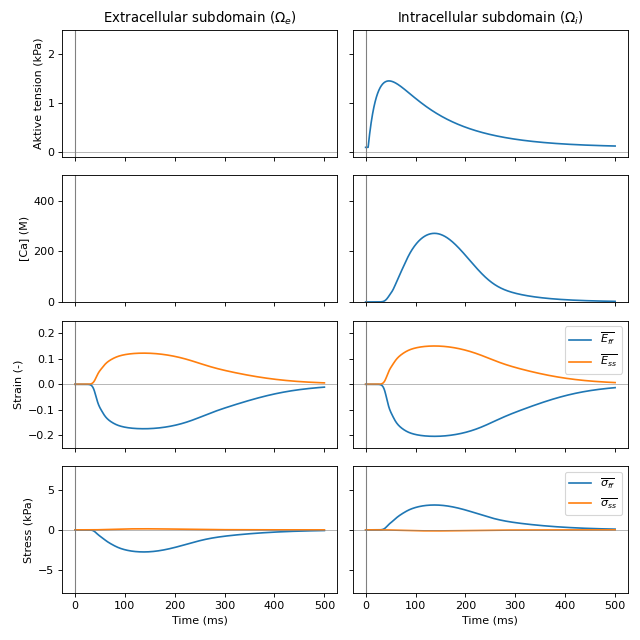

interactive(children=(FloatSlider(value=0.0, description='stiffness_scale_exp', max=4.5, min=-4.0, step=0.5), …

In [2]:
%matplotlib notebook
import ipywidgets as widgets
import numpy as np
from emi_mech_widget import EMI_mech_widget

emw = EMI_mech_widget()

@widgets.interact(stiffness_scale_exp=(-4, 4.5, 0.5), ca_scale=(0.5, 1.55, 0.05))
def f(stiffness_scale_exp=0, ca_scale=1):
    stiffness_scale = 2**stiffness_scale_exp
    print(stiffness_scale, ca_scale)
    emw.update_plot(stiffness_scale, ca_scale)